## Import 

In [9]:
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service
from selectolax.lexbor import LexborHTMLParser
import os, json
from typing import List, Dict, Callable
import time, random, re
import pandas as pd
import requests
import io
from io import BytesIO
from io import StringIO
from bs4 import BeautifulSoup

In [10]:
def parse(parser: Callable, organic_results_data: Callable):
    '''
    Arugments:
    - parser:  Lexbor parser from scrape_google_scholar_organic_results() function.
    - organic_results_data: List to append data to. List origin location is scrape_google_scholar_organic_results() function. Line 104.
    
    This function parses data from Google Scholar Organic results and appends data to a List.
    
    It's used by scrape_google_scholar_organic_results().
    
    It returns nothing as it appends data to `organic_results_data`, 
    which appends it to `organic_results_data` List in the scrape_google_scholar_organic_results() function.
    '''
    
    for result in parser.css('.gs_r.gs_or.gs_scl'):
        try:
            title: str = result.css_first('.gs_rt').text()
        except: title = None

        try:
            title_link: str = result.css_first('.gs_rt a').attrs['href']
        except: title_link = None

        try:
            publication_info: str = result.css_first('.gs_a').text()
        except: publication_info = None

        try:
            snippet: str = result.css_first('.gs_rs').text()
        except: snippet = None

        try:
            # if Cited by is present in inline links, it will be extracted
            cited_by_link = ''.join([link.attrs['href'] for link in result.css('.gs_ri .gs_fl a') if 'Cited by' in link.text()])
        except: cited_by_link = None
        
        try:
            # if Cited by is present in inline links, it will be extracted and type cast it to integer
            cited_by_count = int(''.join([re.search(r'\d+', link.text()).group() for link in result.css('.gs_ri .gs_fl a') if 'Cited by' in link.text()]))
        except: cited_by_count = None
        
        try:
            pdf_file: str = result.css_first('.gs_or_ggsm a').attrs['href']
        except: pdf_file = None

        organic_results_data.append({
            'title': title,
            'title_link': title_link,
            'publication_info': publication_info,
            'snippet': snippet if snippet else None,
            'cited_by_link': f'https://scholar.google.com{cited_by_link}' if cited_by_link else None,
            'cited_by_count': cited_by_count if cited_by_count else None,
            'pdf_file': pdf_file
        })

def scrape_google_scholar_organic_results(
                                        query: str,
                                        pagination: bool = False,
                                        operating_system: str = 'Windows' or 'Linux',
                                        year_start: int = None,
                                        year_end: int = None,
                                        save_to_csv: bool = False, 
                                        save_to_json: bool = False
                                        ) -> List[Dict[str, str]]:
    '''
    Extracts data from Google Scholar Organic resutls page:
    - title: str
    - title_link: str
    - publication_info: str 
    - snippet: str
    - cited_by_link: str 
    - cited_by_count: int
    - pdf_file: str
    
    Arguments:
    - query: str. Search query. 
    - pagination: bool. Enables or disables pagination.
    - operating_system: str. 'Windows' or 'Linux', Checks for operating system to either run Windows or Linux verson of chromedriver
    
    Usage:
    data = scrape_google_scholar_organic_results(query='blizzard', pagination=False, operating_system='win') # pagination defaults to False 
    
    for organic_result in data:
        print(organic_result['title'])
        print(organic_result['pdf_file'])
    '''
    assert year_start and year_end
    if year_start or year_end:
        assert year_start and year_end
        assert year_start <= year_end

    # selenium stealth
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    
    options.add_experimental_option('excludeSwitches', ['enable-automation'])
    options.add_experimental_option('useAutomationExtension', False)
    
    # checks for operating system to either run Windows or Linux verson of chromedriver
    # expects to have chromedriver near the runnable file
    if operating_system is None:
        raise Exception('Please provide your OS to `operating_system` argument: "Windows" or "Linux" for script to operate.')
    
    if operating_system.lower() == 'windows' or 'win':
        driver = webdriver.Chrome(options=options, service=Service(executable_path='chromedriver.exe'))
    
    if operating_system.lower() == 'linux': 
        driver = webdriver.Chrome(options=options, service=Service(executable_path='chromedriver'))
    
    stealth(driver,
        languages=['en-US', 'en'],
        vendor='Google Inc.',
        platform='Win32',
        webgl_vendor='Intel Inc.',
        renderer='Intel Iris OpenGL Engine',
        fix_hairline=True,
    )
    
    page_num: int = 0
    organic_results_data: list = []
    
    if pagination:
        while True:
            # parse all pages
            driver.get(f'https://scholar.google.com/scholar?q={query}&hl=en&gl=us&start={page_num}&as_ylo={year_start}&as_yhi={year_end}')
            parser = LexborHTMLParser(driver.page_source)
            parse(parser=parser, organic_results_data=organic_results_data)
            
            # pagination
            if parser.css_first('.gs_ico_nav_next'):  # checks for the "Next" page button
                page_num += 10                         # paginate to the next page
                time.sleep(random.randint(1, 7))      # sleep between paginations
            else:
                break
    else:
        # parse single, first page
        driver.get(f'https://scholar.google.com/scholar?q={query}&hl=en&gl=us&start={page_num}')
        parser = LexborHTMLParser(driver.page_source)
    
        parse(parser=parser, organic_results_data=organic_results_data)
        
    if save_to_csv:
        pd.DataFrame(data=organic_results_data).to_csv('google_scholar_organic_results_data.csv', 
                                                        index=False, encoding='utf-8')
    if save_to_json:
        pd.DataFrame(data=organic_results_data).to_json('google_scholar_organic_results_data.json', 
                                                        index=False, orient='records')
    driver.quit()
    return organic_results_data

## Add target column from neuromab database

In [11]:
def AddTargetCol(df,final_df):
    '''
    Creates a list of the Target Item from the Neuromab dataframe website to append to final df
    
    Inputs : 
    df - neuromab df fom site 
    final_df - dataframe that is having column added 
    
    Returns : 
    The new dataframe with the added column 
    '''     
    merged_df = final_df.merge(
        
        df[['Clone', 'Target']], left_on=['Antibody'],right_on=['Clone'], how='left'
    
    )
    merged_df = merged_df.drop('Clone', axis=1)
   
    return merged_df

## Grab Neuromab DataFrame from site

In [12]:
data_Neuromab = requests.get("https://neuromab.ucdavis.edu/catalog-download.cfm").content
df = pd.read_csv(BytesIO(data_Neuromab))

## Create URL

In [13]:
def CreateURL(query_name, TCSupe, PureID, NeuromabinQuery,MabIDinQuery,TCSupeInQuery,PureInQuery):
    '''
    Creates a URL to search Google Scholar for the results number at the top of the page 
    
    Inputs : 
    query_name = name of the antibody 
    TCSupe = the TC ID of AB
    PureID = Pure ID of AB
    NeuromabinQuery = Boolean value of whether or to put 'Neuromab' in the search 
    MabIDinQuery = Boolean value of whether or to put the Mab ID in the search
    TCSupeInQuery = Boolean value of whether or to put the TCSupe ID in the search
    PureInQuery = Boolean value of whether or to put the Pure ID in the search
    
    Returns : 
    a constructed URL to search 
    
    '''
    if NeuromabinQuery:
        First_name = 'Neuromab'
    else: 
        First_name = 'Antibodies+Inc'
        
    if MabIDinQuery:
        MABpt1, MABpt2 = query_name.split('/') 
        # EX URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=“Neuromab+%22+%22N289%2F16%22&btnG=
        # EX query Search : “Neuromab ""N289/16" or "Antibodies Inc""N289/16"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}%22+%22{MABpt1}%2F{MABpt2}%22&btnG="
        )
    if TCSupeInQuery:
        # Ex URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Neuromab%22%2273-008%22&btnG=
        # Ex Query : "Neuromab""73-008" or "Antibodies Inc""73-008"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}%22%22{TCSupe}%22&hl=en&as_sdt=0%2C5&as_ylo=2005&as_yhi=2023"
        )
    if PureInQuery:
        # Ex URL : https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22Neuromab%22%2275-008%22&btnG=
        # Ex Query : "Neuromab""75-008" or "Antibodies Inc""75-008"
        url = (
        f"https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=%22'{First_name}%22%22{PureID}%22&hl=en&as_sdt=0%2C5&as_ylo=2005&as_yhi=2023"
        )
            
    return url

## Define location of resulting dataframes

In [14]:
def SetResultDirectory():
    '''
    Returns desired directory for created dataframes 
    '''
    directory = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/final_dfs'
    
    return directory 

 ## Define location of Summary dataframe

In [15]:
def SetSummaryDirectory():
    '''
    Returns the location of where to put the summary table 
    '''
    directory = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/runresults.xlsx'
    
    return directory

## Create Dataframe function 

In [16]:
def CreateDF(query_name, result_value, data, GS_directory, filename, Iteration_num):
    '''
    
    Creates a dataframe of the search results from Google scholar, prints different alert depending 
    on how many papers are different from search result number and results found from scraping GS
    
    Inputs : 
    query_name = the neuromab ID 
    result_value = the number of results found from a search, used to compare to google 
                    scholar scraper results 
    data = the tabel created from the google scholar search results 
    GS_directory = the location of the table from the google scholar search reesults 
    filename = the neuromab ID
    Iteration_num = the column that is being searched through, creates different results based on 
                    iteration number 
                    
    Returns : 
    a dataframe of the search results from a single search 
    
    '''
    data_length = int({len(data)}.pop())
    print(f'Length of created dataframe is {data_length}')
    
    filename = filename.replace('/','_')

    # Record the difference between search result # and data length 
    count = (int(result_value)) - (int(data_length))
    final_df = pd.DataFrame(data)
    
    # Get rid of extraneous strings from title 
    final_df['title'] = final_df['title'].str.replace(
        '\[HTML\]\[HTML\]|\[PDF\]\[PDF\]|\[CITATION\]|\[C\]|\[BOOK\]\[BOOK\]|\[B\]|\[BOOK\]\[B\]', ''
    )

    # Input Antibody name into table 
    final_df["Antibody"] = query_name 
    final_df = AddTargetCol(df,final_df)
    final_df.to_csv(os.path.join(GS_directory, filename), index=False)
    print(f'{filename} saved to {GS_directory}')
    
    # Input different result string based on difference in count 
    if count == 0:
        print(f'{query_name} All {data_length} accounted for: DF saved to file')
        runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'All {data_length} accounted for'
    elif (count < (int(result_value) * .8)) and (count > 0):
        print(f'{query_name} : Out of {data_length} there seems to be {count} paper(s) w/o years')
        runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'There seems to be {count} paper(s) w/o years, out of {data_length}'
    else:
        print(f'{query_name} Out of {data_length}, {count} paper(s) w/o years')
        runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = f'Out of {data_length}, {count} paper(s) are w/o year(s)'


    return final_df

### Random sleep time Generator 

In [17]:
def RandomWait():
    '''
    This returns a random time between 5 and 10 sec for the 
    program to wait between requests
    '''
    return random.randint(5, 10)

## Scholar Query : search into google scholar and grab data from query 

In [22]:
def Scholar_Query(leftoff, Iteration_num):
    '''
    Main Scraping function 
    
    Args : 
    
        - leftoff (int) takes the row number of the summary dataframe from where you would
        like to start your search 
        
        - Iteration_num (int) defines from what row to take information for query 
    
    Returns : 
    
        - dataframes for each successful GS search, containing information 
    on the paper that mentions a neuromab 
    
        - also updates the summary dataframe which shows results from searches 
        i.e. how many papers were found for each antibody, and where the search 
        left off 
        
    '''
    ## pass directory names to functions 

    # Initialize a value to count 0 result pages 
    zero_result_counter = 0

    # Initialize result directory path
    GS_directory = SetResultDirectory()

    # Initialize summary directory path and df
    SUM_df = SetSummaryDirectory()
    runresultsdf = pd.read_excel(SUM_df)

    for index, row in runresultsdf.iloc[leftoff:].iterrows():
        data = {}
        query_name = row['Clone']
        TCSupe = row['AICatalogTCSupe']
        PureID = row['AICatalogPure']

        print(f"\nStarting Google Scholar scrape for {query_name}, Iteration {str(Iteration_num)}, Row {str(row[0])}...")


        # Set query for google scholar 
        # Example: “Neuromab " "N289/16"
        # and create URL to grab search results number
        # and set filename for query df 

        if Iteration_num == 1:
            query = (
                '"Neuromab"' +  
                f'"{query_name}"' 
            )
            url = CreateURL(query_name, 
                             TCSupe, 
                             PureID, 
                             NeuromabinQuery=True, 
                             MabIDinQuery=True,
                             TCSupeInQuery=False,
                             PureInQuery=False
                        )
            filename = f'Neuromab_{query_name}.csv'

        if Iteration_num == 2:
            query = (
                '"Neuromab"' +  
                f'"{TCSupe}"' 
            )
            url = CreateURL(query_name, 
                             TCSupe, 
                             PureID, 
                             NeuromabinQuery=True, 
                             MabIDinQuery=False,
                             TCSupeInQuery=True,
                             PureInQuery=False
                        )
            filename = f'Neuromab_{TCSupe}.csv'

        if Iteration_num == 3:
            query = (
                '"Neuromab"' +  
                f'"{PureID}"' 
            )
            url = CreateURL(query_name, 
                             TCSupe, 
                             PureID, 
                             NeuromabinQuery=True, 
                             MabIDinQuery=False,
                             TCSupeInQuery=False,
                             PureInQuery=True
                        )
            filename = f'Neuromab_{PureID}.csv'

        if Iteration_num == 4:
            query = (
                '"Antibodies Inc"' +  
                f'"{query_name}"' 
            )
            url =  CreateURL(query_name, 
                             TCSupe, 
                             PureID, 
                             NeuromabinQuery=False, 
                             MabIDinQuery=True,
                             TCSupeInQuery=False,
                             PureInQuery=False
                        )
            filename = f'AntibodiesInc_{query_name}.csv'

        if Iteration_num == 5:
            query = (
                '"Antibodies Inc"' +  
                f'"{TCSupe}"' 
            )
            url =  CreateURL(query_name, 
                             TCSupe, 
                             PureID, 
                             NeuromabinQuery=False, 
                             MabIDinQuery=False,
                             TCSupeInQuery=True,
                             PureInQuery=False
                        )
            filename = f'AntibodiesInc_{TCSupe}.csv'

        if Iteration_num == 6:
            query = (
                '"Antibodies Inc"' +  
                f'"{PureID}"' 
            )
            url =  CreateURL(query_name, 
                             TCSupe, 
                             PureID, 
                             NeuromabinQuery=False, 
                             MabIDinQuery=False,
                             TCSupeInQuery=False,
                             PureInQuery=True
                        )
            filename = f'AntibodiesInc_{PureID}.csv'


        print(f"Query is {query}")
        # Grab data from google scholar 
        data = scrape_google_scholar_organic_results(query=query,
                                                     pagination=True,
                                                     operating_system="Windows",
                                                     year_start=2005,
                                                     year_end=2024
                                                )


        print(f'URL is {url}')
        url_info = requests.get(url)
        time.sleep(RandomWait())
        html = url_info.text

        # Create a BeautifulSoup object from the HTML string
        soup = BeautifulSoup(html, 'html.parser')
        result_elem = soup.select_one('#gs_ab_md .gs_ab_mdw')

        # Create text from Google Scholar Page and find search results number. 
        if result_elem:
            result_text = result_elem.get_text(strip=True)
            result_match = re.search(r'(\d+[\d,]*)\s+results', result_text)

            if result_match == None:
                result_match = re.search(r'(\d+[\d,]*)\s+result', result_text)

            if result_match:
                result_value = result_match.group(1)
                result_value = result_value.replace(',', '')
                print(f'Results search value is {result_value}')

                final_df = CreateDF(query_name,
                                    result_value,
                                    data, 
                                    GS_directory,
                                    filename,
                                    Iteration_num
                                )

            else:
                print(f'{query} No research Published')
                runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = "No research Published"


        else:
            print(f'{query} No result element, we got dropped')
            runresultsdf.loc[runresultsdf['Clone'] == query_name, 'Iteration '+str(Iteration_num)] = 'No result element, we got dropped'
            zero_result_counter += 1
            if zero_result_counter >= 1:
                print(f'Ending Scraper on {query_name} row {str(row[0])}')
                # Iterate through the columns and delete any that start with "Unnnamed"
                for col in runresultsdf.columns:
                    if col.startswith("Unnamed"):
                        runresultsdf = runresultsdf.drop(col, axis=1)
                runresultsdf.to_excel(SUM_df)
                print(f'Summary Result Table saved to {SUM_df}')
                break

In [23]:
Scholar_Query(50, 5)


Starting Google Scholar scrape for N4/49, Iteration 5, Row 50...
Query is "Antibodies Inc""73-061"


KeyboardInterrupt: 

In [19]:
leftoff = row[0]

leftoff

54

## Dataframe creation for Neuromab Site


In [1]:
# Collection of all of the created dataframes from each search result 
import os
import pandas as pd
df_list = []
path_to_files = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/final_dfs'
path_to_csv = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/publications_neuromab_df.csv'
for file in os.listdir(path_to_files):
    if '.csv' in file:
        print(file)
        query = pd.read_csv(f"{path_to_files}/{file}")
        query["query"] = file.split(".")[0]
        df_list.append(query)

publications_neuromab_df = pd.concat(df_list)

# Drop columns by their column number (index)
columns_to_drop = [1,2,3,4,5,6,9]  # Column numbers to drop
publications_neuromab_df.drop(publications_neuromab_df.columns[columns_to_drop], axis=1, inplace=True)

# Group by 'title' column and aggregate 'antibody' column using a custom function
def concatenate_antibodies(antibodies):
    return ', '.join(set(antibodies))  # Join unique antibodies with commas

def concatenate_targets(targets):
    return ', '.join(set(targets))  # Join unique targets with commas

publications_neuromab_df['Antibody'] = publications_neuromab_df.groupby('title')['Antibody'].transform(concatenate_antibodies)

publications_neuromab_df['Target'] = publications_neuromab_df.groupby('title')['Target'].transform(concatenate_targets)

# Drop duplicate rows based on 'title' column
publications_neuromab_df.drop_duplicates(subset='title', keep='first', inplace=True)

# Reset the index
publications_neuromab_df.reset_index(drop=True, inplace=True)

publications_neuromab_df = publications_neuromab_df.rename(columns={'title': 'Title','Antibody':'Neuromab(s)','Target':'Target(s)'})
                       
publications_neuromab_df.to_csv(path_to_csv)

Neuromab_75-006.csv
Neuromab_75-012.csv
Neuromab_73-080.csv
AntibodiesInc_75-250.csv
neuromabN37A_10.csv
Neuromab_73-057.csv
neuromabN212_17.csv
Neuromab_73-043.csv
AntibodiesInc_75-287.csv
Neuromab_75-204.csv
Neuromab_73-296.csv
Neuromab_N230_21.csv
Neuromab_73-282.csv
Neuromab_75-210.csv
neuromabN144_14.csv
Neuromab_73-241.csv
Neuromab_73-269.csv
Neuromab_K89_34.csv
AntibodiesInc_N134_12.csv
Neuromab_75-416.csv
Neuromab_75-402.csv
AntibodiesInc_75-126.csv
Neuromab_75-358.csv
Neuromab_73-321.csv
Neuromab_N336B_83.csv
Neuromab_73-309.csv
neuromabN385_21.csv
AntibodiesInc_75-318.csv
Neuromab_75-172.csv
Neuromab_75-166.csv
AntibodiesInc_L18A_3.csv
Neuromab_N377_20.csv
AntibodiesInc_K28_43.csv
neuromabN23B_49.csv
Neuromab_N151_3.csv
AntibodiesInc_75-330.csv
Neuromab_73-123.csv
Neuromab_73-137.csv
Neuromab_N345_51.csv
Neuromab_75-198.csv
Neuromab_K19_36.csv
Neuromab_N57_2.csv
AntibodiesInc_N271_44.csv
Neuromab_73-136.csv
Neuromab_73-122.csv
neuromabN125_10.csv
AntibodiesInc_75-325.csv
Neur

,Title,Neuromab(s),Target(s)
0,Mutant huntingtin enhances activation of dendr...,"L28/4, K57/1, K60/73, K55/82, K14/16","Kv4.2 K+ channel, Pan-KChIP K+ channel, KChIP2..."
1,A novel bungarotoxin binding site-tagged const...,"K57/1, K55/82","Pan-KChIP K+ channel, Kv4.2 K+ channel (external)"
2,Intracellular Angiotensin‐II interacts with nu...,K55/82,Pan-KChIP K+ channel
3,Intracellular and non-neuronal targets of volt...,"K19/36, K36/15, K14/16","Kv1.1 K+ channel (external), Kv1.6 K+ channel,..."
4,Localization of Kv1. 3 channels in presynaptic...,"K20/78, K19/36, L23/27, K14/16","Kv1.6 K+ channel, Kv1.2 K+ channel, Kv1.3 K+ c..."
...,...,...,...
4373,Sexually divergent mortality and partial pheno...,K74/71,Nav1.1 Na+ channel
4374,Antisense oligonucleotide modulation of non-p...,K74/71,Nav1.1 Na+ channel
4375,Relative Quantification of NaV1. 1 Protein in ...,K74/71,Nav1.1 Na+ channel
4376,Delivery of Sodium Channel Subunits via Viral ...,K74/71,Nav1.1 Na+ channel


In [89]:
from pymed import PubMed

def add_pubmed_info_to_df(df, leftoff):
    """
    Adds PubMed information (PMID, publication date, author names and journal) as separate columns to a DataFrame.

    Args:
        - df (pandas DataFrame): DataFrame to update.
        - leftoff (int): Index where the search last left off (search element is occasionally dropped).

    Returns:
        pandas DataFrame: Updated DataFrame with added columns for PubMed information.
    """

    pubmed = PubMed(tool="MyTool", email="my@email.address")
    
    path_to_csv = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/publications_neuromab_df.csv'

    for index, row in df.iloc[leftoff:].iterrows():
        title_query = row['Title']

        # Check if 'PubMed' column and row is empty
        #if pd.isna(df.at[index, 'PubMed']):
            #results = pubmed.query(str(title_query), max_results=1)

        if results:
            for i in results:
                PMID = i.pubmed_id
                PMID = PMID[0:8]
                df.at[index, 'PubMed'] = PMID

                print(f"PubMed ID is {PMID}")

                df.at[index, 'Date'] = i.publication_date
                print(f"Date of publication is {i.publication_date}")

                authors = i.authors
                # Extracting the first author's lastname
                first_author_lastname = authors[0]['lastname']

                # Creating the "et al" part
                et_al = "et al"

                # Creating the formatted string for publication info
                publication_info = f"{first_author_lastname} {et_al}. {i.journal}"
                df.at[index, 'Publication'] = publication_info
                print(f"Publication info: {publication_info}")

                # Save the updated DataFrame to a CSV file after each iteration
                df.to_csv(path_to_csv, index=False)

        else:
            print(f"Pubmed Info Accumulation ended on {title_query}")
            return df

        # Save the updated DataFrame to a CSV file after each iteration
        df.to_csv(path_to_csv, index=False)

    return df


In [90]:
# Designate dataframe to add pubmed info to 
import pandas as pd
path_to_csv = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/publications_neuromab_df.csv'
path_to_xlsx = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/publications_neuromab_df.xlsx'
neuromab_df = pd.read_csv(path_to_csv)

# Call the pubmed info function 
neuromab_df = add_pubmed_info_to_df(neuromab_df, 2000)

# Converting csv dataframe to xlsx format 
import pandas as pd

# Read the CSV file
neuromab_df = pd.read_csv(path_to_csv)

# Convert the CSV to XLSX
neuromab_df.to_excel(path_to_xlsx, index=False)

## Analysis

In [104]:
# Average number of Antibodies per publication 

import pandas as pd

path_to_csv = '/Users/HMans_MacBook_Pro/Desktop/T.Lab/Final_df.csv'

# Sample dataframe
neuromab_df = pd.read_csv(path_to_csv)

# Function to count items in a comma-separated string
def count_items(row):
    return len(row['Neuromab(s)'].split(','))

# Apply the function to each row and store the counts in a new column
neuromab_df['Number of AB\'s'] = neuromab_df.apply(count_items, axis=1)

# Display the updated dataframe
#print(neuromab_df)

# Calculate the average of the values in the 'Number of AB\'s' column
average = neuromab_df['Number of AB\'s'].mean()

# Display the average
print("Average number of AB's used in each publication: ", average)


Average number of AB's used in each publication:  1.5443124714481498


In [132]:
# Number of Publications without PubMed ID 
import pandas as pd

# Count the number of empty values in the 'Publication' column
count = 0
for pub in neuromab_df['Publication']:
    if pd.isna(pub) or pub == '':
        count += 1

# Get the total number of rows in the DataFrame
rows = len(neuromab_df)

# Print the count of publications without a PubMed ID and the total number of rows
print(f'The total number of publication results is {rows}')
print(f'The number of publications with a PubMed ID is {rows - count} - ({count} without PMID)')



The total number of publication results is 4378
The number of publications with a PubMed ID is 3235 - (1143 without PMID)


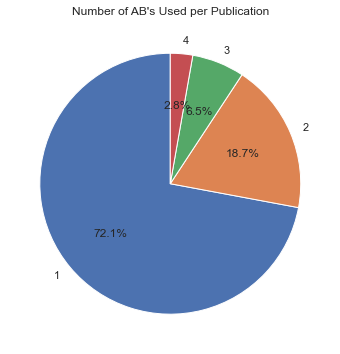

In [111]:
# Set a threshold for percentage display
threshold = 1.5 # Only display percentages above 1.5%

# Create a pie chart of the different numbers of antibodies used
# Count the occurrences of each unique value in 'Number of AB\'s' column
count_by_number = neuromab_df['Number of AB\'s'].value_counts()

# Calculate percentage for each count
percentages = count_by_number / count_by_number.sum() * 100

# Filter percentages based on threshold
filtered_percentages = percentages[percentages > threshold]

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(filtered_percentages, labels=filtered_percentages.index, autopct='%1.1f%%', startangle=90)
plt.title('Number of AB\'s Used per Publication')
plt.show()

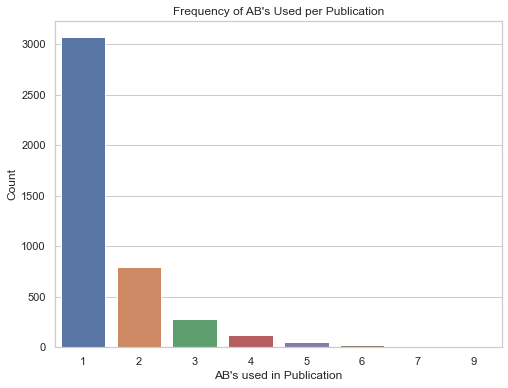

In [134]:
# Set a threshold for bar plot display
threshold = 5 # Only display bars for counts above 5%

# Count the occurrences of each unique value in 'Number of AB\'s' column
count_by_number = neuromab_df['Number of AB\'s'].value_counts()

# Filter counts based on threshold
filtered_count_by_number = count_by_number[count_by_number > threshold]

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=filtered_count_by_number.index, y=filtered_count_by_number.values)
plt.xlabel('AB\'s used in Publication')
plt.ylabel('Count')
plt.title('Frequency of AB\'s Used per Publication')
plt.show()

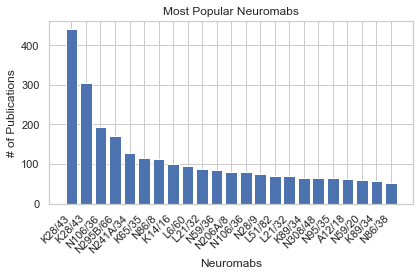

In [144]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the 'Neuromab(s)' column as a Series
neuromabs = neuromab_df['Neuromab(s)']

# Create a dictionary to store the counts of each item
item_counts = {}

# Iterate through the 'Neuromab(s)' column in the DataFrame
for row in neuromabs:
    # Split the items by commas
    items = row.split(',')
    # Iterate through the items and update the counts
    for item in items:
        if item in item_counts:
            item_counts[item] += 1
        else:
            item_counts[item] = 1

# Sort the items by count in descending order
sorted_items = sorted(item_counts.items(), key=lambda x: x[1], reverse=True)
items = [item[0] for item in sorted_items]
counts = [item[1] for item in sorted_items]

# Filter items with count above 50
items_filtered = [item for item, count in zip(items, counts) if count > 50]
counts_filtered = [count for count in counts if count > 50]

# Create a bar plot for filtered items
plt.bar(items_filtered, counts_filtered)
plt.xlabel('Neuromabs')
plt.ylabel('# of Publications')
plt.title('Most Popular Neuromabs')
# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

